### 0. Google Colab 환경 세팅

- 런타임 유형 변경: T4 GPU (저장)

### 1. 내 드라이브 연결 (1~2분 소요)

- 내 드라이브 연결
- 작업 Directory 이동

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# practice로 폴더 생성하지 않고 본인의 폴더명을 별도로 설정하였을 경우, 해당 폴더명을 넣어주기
%cd ./drive/MyDrive/practice

/content/drive/MyDrive/practice


In [3]:
# 현재 directory 확인
%pwd

'/content/drive/MyDrive/practice'

### 2. 분석에 필요한 모듈 및 라이브러리 설치

- Google colab에서 기본적으로 제공하는 모듈도 있음
- 이 외 모듈은 pip install 명령어를 통해 설치
- 설치에는 2~3분 소요

In [4]:
# pip install 설치 명령어

# 데이터 - excel 파일 열기
!pip install openpyxl

# 모델
!pip install transformers
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=089c096d477afe1170261e2f60823193738881232fc266202121f5ede04389c3
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


### 3. 설치된 모듈 및 라이브러리 불러오기

In [5]:
# 데이터 처리
import pandas as pd
import numpy as np

# 기본
import time

# 진행 과정 시각화
from tqdm.notebook import tqdm

# 모델 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertPreTrainedModel, BertModel, BertConfig, BertTokenizer, AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, models, util
from sentence_transformers.cross_encoder import CrossEncoder

### 4. 분석할 데이터 불러오기

- 소아암 생존자 Q&A 데이터셋

In [6]:
#  데이터 읽기
df = pd.read_excel('data2.xlsx')

# 데이터 첫 5행 읽기
df.head()

# 마지막 5행 읽기
# df.tail()

,question,answer
0,체력이 약화되어 쉽게 피로함을 느껴요.,분명히 남들보다 피로해하는 것은 맞는 것 같고요. 체력이 다른 사람들과 비교했을 때...
1,쉽게 피로해져서 학교 생활에도 제약이 있어요.,뭘 조금만 무리를 하면은 그게 몸에서 반응이 와요. 막 조금만 피곤하게 뭐 공부를 ...
2,수술 후 후유증으로 힘들어요.,방사선 하다 보니까 머리도 가늘어지고 머리 숱도 별로 없더라고요. 그래서 흉터가 보...
3,수술 후유증인지 여성 호르몬 수치가 이상해요.,여성호르몬이 좀 이상하다는 거에요. 인슐린이랑 여성 호르몬 수치가 좀 이상하다고 하...
4,수술 후유증때문에 힘들어요.,"제가 고등학생 때 허리 디스크가 있었는데, 수업 빠질 정도로 가볍지 않은 디스크였어..."


In [7]:
# 데이터 확인

# 데이터 컬럼명 확인
print(df.columns)

# 데이터 정보 확인
print(df.info())

# 데이터 길이 확인
print(len(df))

Index(['question', 'answer'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  426 non-null    object
 1   answer    426 non-null    object
dtypes: object(2)
memory usage: 6.8+ KB
None
426


### 5. Cross-encoder로 Semantic Textual Similarity(STS) 수행

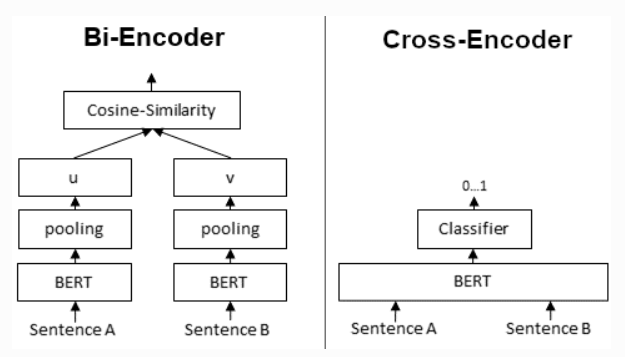

- sbert: https://www.sbert.net/docs/pretrained_models.html
- korean sbert (cross-encoder): https://huggingface.co/bongsoo/klue-cross-encoder-v1

In [19]:
# 사전 학습 BERT model

cross_encoder = CrossEncoder('bongsoo/kpf-cross-encoder-v1') # hugging face 사전 학습 모델 download

In [38]:
# Testing Question
query = '남들보다 친구를 사귀기 어려운 것 같아요.'

# Corpus
question_data = [
    '친구들이 외모 때문에 놀려요.',
    '탈모로 힘들어요.',
    '탈모는 안좋아요.',
    '머리 숱이 너무 없어요.',
    '학교로 돌아갈 수 있으려나.',
    '내가 뭘 잘 할 수 있는지 모르겠어요.',
    '피곤하다.'
    ]

# Cross-encoder input 구조
input_sentence = [[query, question] for question in question_data]

# Compute similarity between two sentences
start = time.time()
similarity_scores = cross_encoder.predict(input_sentence)
end = time.time()

response_time = end-start
print('계산 소요시간:', response_time)
print()

# sort the scores in decreasing order
sim_scores_argsort = np.argsort(similarity_scores)[::-1]

# Print the scores
print("Query:", query)
for idx in sim_scores_argsort:
    print("{:.2f}\t{}".format(similarity_scores[idx], question_data[idx]))

계산 소요시간: 0.7513315677642822

Query: 남들보다 친구를 사귀기 어려운 것 같아요.
0.17	친구들이 외모 때문에 놀려요.
0.06	내가 뭘 잘 할 수 있는지 모르겠어요.
0.01	탈모로 힘들어요.
0.01	머리 숱이 너무 없어요.
0.01	학교로 돌아갈 수 있으려나.
0.01	피곤하다.
0.01	탈모는 안좋아요.


In [39]:
# 우리 데이터에 적용
# Cross-encoder input 구조
input_sentence = [[query, question] for question in df['question']]

# Compute similarity between two sentences
start = time.time()
similarity_scores = cross_encoder.predict(input_sentence)
end = time.time()

response_time = end-start
print('계산 소요시간:', response_time)

# sort the scores in decreasing order
sim_scores_argsort = np.argsort(similarity_scores)[::-1]

# Print the scores
crossencoder_question = []
print("Query:", query)
for idx in sim_scores_argsort[:20]: # 상위 5개만 출력
    print("{:.2f}\t{}".format(similarity_scores[idx], df['question'][idx]))
    crossencoder_question.append(df['question'][idx])

계산 소요시간: 71.95671701431274
Query: 남들보다 친구를 사귀기 어려운 것 같아요.
0.58	친구들과 관계 형성하는게 어려워요.
0.55	친구들한테 먼저 다가가는게 좀 어려워요.
0.45	좀 다양한 사람들을 만나고 친해지고 싶은 마음은 있는데 쉽지 않은 것 같아요.
0.44	치료시기에 또래들과 어울리는 것이 제한되었어서 사회성이 저하된 것 같아요.
0.44	대인관계 폭이 계속 좁아지고 있는 것 같은데 괜찮을까요?
0.43	제가 다시 친구들과 잘 어울릴 수 있을지 잘 모르겠어요.
0.41	이성친구와의 관계에 있어서 쉽게 다가가지 못하겠어요.
0.40	사회성이 많이 저하된 것 같아요.
0.40	처음 사람들, 또래 친구들에게 다가가는게 어려워요. 어떻게 말을 해야할지 막막한 기분이에요.
0.40	다른 사람들이랑 외형적으로 좀 다르니깐 친구들이 안 다가오는 것 같아요.
0.36	아팠을 때는 더 사람을 만나기 꺼려했었던 것 같아요.
0.36	학교 생활로 다시 돌아가도 일반적으로 지내기는 힘든 것 같아요.
0.35	또래 친구들이 많이 없어요. 자조모임에 나가면 또래를 만날 수 있나요?
0.34	학교에서 친구들이랑 어울릴 때 어려운 점이 있었나요?
0.34	저는 대인관계가 어려운데 모임에 나가면 좀 바뀔 수 있을까요?
0.33	사람을 사귀다 보면 저를 싫어하는 사람도 생기잖아요. 저를 미워하는 사람을 어떻게 대하면 좋을지 모르겠어요.
0.33	사람들이 저를 싫어할 것 같아서 일부로 더 멀리하는 것 같아요.
0.32	다시 친구들 만났을 때 어떤 점이 힘든가요?
0.32	학교에 돌아가서 친구들과 원만한게 어울리는 데 많은 어려움을 겪고 있어요.
0.31	남들과 다르게 보이면 관계에서 거절당할까봐 미리 방어적인 태도를 취하는 것 같아요.


### 6. Bi-encoder로 STS 수행

- korean sbert: https://huggingface.co/snunlp/KR-SBERT-V40K-klueNLI-augSTS

In [15]:
bi_encoder = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [16]:
# bi-encoder 사전 embedding
new_question_embedding = []

for question in tqdm(df['question']):
    embedding = bi_encoder.encode(question, convert_to_tensor = True)
    new_question_embedding.append(embedding)

print(len(new_question_embedding))

  0%|          | 0/426 [00:00<?, ?it/s]

426


In [26]:
# embedding 파일 별도 저장
import pickle

result = new_question_embedding

# embedding 값 저장
with open("question_emb.pkl","wb") as f:
    pickle.dump(result, f)

# embedding 파일 불러오기
with open("question_emb.pkl", 'rb') as f:
    new_question_embedding = pickle.load(f)

In [18]:
len(new_question_embedding)

426

In [27]:
new_question_embedding

Output hidden; open in https://colab.research.google.com to view.

In [48]:
# Testing Question
query = '자조모임이 뭔가요?'

# bi-encoder input 구조
user_emb = bi_encoder.encode(query, convert_to_tensor = True)

# Compute similarity between two sentences
start = time.time()

similarity_score = []
for i in range(len(new_question_embedding)):
    cos_score = util.pytorch_cos_sim(user_emb, new_question_embedding[i])[0]
    similarity_score.append(cos_score)

end = time.time()

response_time = end-start
print('계산 소요시간:', response_time)
print()

# sort the scores in decreasing order
value_score = sorted(similarity_score, reverse = True)
index_score = sorted(range(len(similarity_score)), key=lambda k: similarity_score[k],reverse=True)

# Print the scores
biencoder_question = []
print("Query:", query)
for idx in index_score[:20]: # 상위 5개만 출력
    print("{:.2f}\t{}".format(similarity_score[idx].item(), df['question'][idx]))
    biencoder_question.append(df['question'][idx])

계산 소요시간: 0.043766021728515625

Query: 자조모임이 뭔가요?
0.85	자조모임은 어떤 공간인가요?
0.71	자조모임에서 배울 수 있는게 있나요?
0.69	자조모임에 나가면 어떨지 궁금해요.
0.64	자조모임에 나갈 때 어떤 마음으로 나가는지 궁금해요.
0.63	자조모임에 참여하고 나서 이전과 달라진 점이 있나요?
0.63	자조모임을 겪은 후에 사회에 나가면 어떤 장점이 있나요?
0.62	자조모임에 나가면 어떤 점이 좋나요?
0.61	소극적이거나 내향적인 사람들도 자조모임에 나가나요?
0.60	자조모임에 참여하면 성격이 바뀌나요?
0.60	자조모임을 나갈지 말지 고민이 돼요. 모임에 가면 좋나요?
0.58	자조모임에 가서 겪은 긍정적인 변화가 있나요?
0.56	자조모임에 가서 역할을 맡아서 수행하면 사회에 나가서도 도움이 될까요?
0.55	자조모임에서 가장 기억에 남는 활동이 있나요?
0.55	자조모임에 나가면 저를 이해해주는 사람을 만날 수 있을까요?
0.54	자조모임 프로그램에 참여하면 장점이 있나요?
0.54	저는 내향적인 성격인데, 자조모임에 나가서 괜찮을지 잘 모르겠어요.
0.54	학교를 안 다니는데 자조모임에 나가도 될까요?
0.52	자조모임에 가면 어떤 부분에서 도움을 받을 수 있나요?
0.51	자조모임에 가면 어떤 점이 좋은지 알고 싶어요.
0.51	자조모임에 나가면 성격이나 성향 같은 것도 바뀌기도 하나요?


**결과 비교**

In [40]:
# cross encoder와 bi encoder 결과 비교
print('비교 입력문:', query)
question = pd.DataFrame()
question['crossencoder'] = crossencoder_question
question['biencoder'] = biencoder_question
question

비교 입력문: 남들보다 친구를 사귀기 어려운 것 같아요.


,crossencoder,biencoder
0,친구들과 관계 형성하는게 어려워요.,친구들과 관계 형성하는게 어려워요.
1,친구들한테 먼저 다가가는게 좀 어려워요.,친구들한테 먼저 다가가는게 좀 어려워요.
2,좀 다양한 사람들을 만나고 친해지고 싶은 마음은 있는데 쉽지 않은 것 같아요.,다른 친구들이랑 많이 어울린 경험이 없어서 그런지 자꾸 주눅들어요. 이런 성격을 고...
3,치료시기에 또래들과 어울리는 것이 제한되었어서 사회성이 저하된 것 같아요.,이성친구와의 관계에 있어서 쉽게 다가가지 못하겠어요.
4,대인관계 폭이 계속 좁아지고 있는 것 같은데 괜찮을까요?,좀 다양한 사람들을 만나고 친해지고 싶은 마음은 있는데 쉽지 않은 것 같아요.
5,제가 다시 친구들과 잘 어울릴 수 있을지 잘 모르겠어요.,"처음 사람들, 또래 친구들에게 다가가는게 어려워요. 어떻게 말을 해야할지 막막한 기..."
6,이성친구와의 관계에 있어서 쉽게 다가가지 못하겠어요.,제 의지와 상관없이 학교며 친구며 모두 단절이 되어버리니깐 더 힘든 것 같아요.
7,사회성이 많이 저하된 것 같아요.,주변 사람들은 매우 지지적인데도 불구하고 학교 적응이 어려운 것 같아요.
8,"처음 사람들, 또래 친구들에게 다가가는게 어려워요. 어떻게 말을 해야할지 막막한 기...",대인관계 폭이 계속 좁아지고 있는 것 같은데 괜찮을까요?
9,다른 사람들이랑 외형적으로 좀 다르니깐 친구들이 안 다가오는 것 같아요.,친구들한테 말이 잘 안 나와요. 괜히 더 서먹해하고 그런게 있는데 자조모임에 나가면...


### 7. 소아암 생존자를 위한 정보 전달형 챗봇

In [49]:
while True:

    print('소아암 생존자:')
    user_context = [str(input())] # 사용자 발화 입력
    start = time.time() # 시작

    # 챗봇 종료 조건
    if user_context == ['종료']:
        check_end = input('대화를 종료할까요? (네/아니오)')
        if check_end == '네':
            print('대화를 종료합니다.')
            time.sleep(1)
            break
        else:
            print('대화를 이어갑니다.')
    else:
        user_emb = bi_encoder.encode(user_context[0], convert_to_tensor = True)

        final_scores = []

        for sim_score in new_question_embedding:
            cos_score = util.pytorch_cos_sim(user_emb, sim_score)[0]
            final_scores.append(cos_score.item())


        # alternative
        alter_response = "해당 질문에 대한 답을 바로 드리기 어렵습니다. 한국백혈병소아암협회에서는 전문의 상담실을 운영하고 있습니다.아래 사이트를 방문하여 궁금하신 내용에 대한 답을 얻는 건 어떨까요? https://soaam.or.kr/business/counseling_Info.php?PHPSESSID=644fd2800457376ea4f84dcc8939fd44"

        if np.max(final_scores) <= 0.5:
            best_response = alter_response
        else:
            # select best response with highest score
            max_prob = np.max(final_scores)
            max_idx = np.argmax(final_scores)

            # final response
            best_response = '비슷한 경험을 한 생존자의 이야기를 들려드릴게요.' + df['answer'][max_idx]

        end = time.time() # 끝

        print("저장된 DB 가장 비슷한 질문:", df['question'][max_idx])
        print("챗봇:")
        print(best_response)
        print("답변까지 소요시간:", end-start, '초')
        print()

소아암 생존자:
자조모임이 뭔가요?
저장된 DB 가장 비슷한 질문: 자조모임은 어떤 공간인가요?
챗봇:
비슷한 경험을 한 생존자의 이야기를 들려드릴게요.한달에 한번씩 밖에 나갈 수 있는 기회요. 계속 집에만 틀어박혀 있다가 한달에 한번 여기에 오는 게 너무 좋은 거에요. 밖에 나갈 일이 없었거든요. 청모 때문에 밖에 나갈 이유가 생겼고, 나가서 만날 친구들이 생겼어요.
답변까지 소요시간: 0.12796664237976074 초

소아암 생존자:
청모가 뭔가요?
저장된 DB 가장 비슷한 질문: 청모에 나가면 좋은 점이 있나요?
챗봇:
비슷한 경험을 한 생존자의 이야기를 들려드릴게요.여기는 일단 편해요. 정말 다 공유할 수 있거든요. 암튼, 청소년 모임은 제 마음의 쉼터에요.
답변까지 소요시간: 0.19174981117248535 초

소아암 생존자:
종료
대화를 종료할까요? (네/아니오)네
대화를 종료합니다.


### 8. Option

- Bi-encoder + Cross-encoder

In [44]:
while True:

    print('소아암 생존자:')
    user_context = [str(input())] # 사용자 발화 입력
    start = time.time() # 시작

    # 챗봇 종료 조건
    if user_context == ['종료']:
        check_end = input('대화를 종료할까요? (네/아니오)')
        if check_end == '네':
            print('대화를 종료합니다.')

        time.sleep(1)
        break

    else:
        rerank_num = int(input())
        user_emb = bi_encoder.encode(user_context[0], convert_to_tensor = True)

        bi_score = []
        rerank_df = pd.DataFrame(columns=['question', 'answer']) # 빈 데이터 프레임 생성

        for sim_score in new_question_embedding:
            cos_score = util.pytorch_cos_sim(user_emb, sim_score)[0]
            bi_score.append(cos_score.item())

        top_idxes = np.argsort(bi_score)[::-1]

        for i in range(rerank_num):
          rerank_df.loc[i] = [df['question'][top_idxes[i]],df['answer'][top_idxes[i]]]

        # cross-encoder input 구조
        input_sentence = [[user_context[0], question] for question in rerank_df['question']]

        # compute similarity between two sentences
        final_scores = cross_encoder.predict(input_sentence)

        # select best response with the highest score
        max_idx = np.argmax(final_scores)

        # alternative
        alter_response = "해당 질문에 대한 답을 바로 드리기 어렵습니다. 한국백혈병소아암협회에서는 전문의 상담실을 운영하고 있습니다.아래 사이트를 방문하여 궁금하신 내용에 대한 답을 얻는 건 어떨까요? https://soaam.or.kr/business/counseling_Info.php?PHPSESSID=644fd2800457376ea4f84dcc8939fd44"

        if np.max(final_scores) <= 0.5:
            best_response = alter_response
        else:
            # select best response with highest score
            max_prob = np.max(final_scores)
            max_idx = np.argmax(final_scores)

            # final response
            best_response = '비슷한 경험을 한 생존자의 이야기를 들려드릴게요.' + rerank_df['answer'][max_idx]

        end = time.time() # 끝

        print("저장된 DB 가장 비슷한 질문:", rerank_df['question'][max_idx])
        print("챗봇:")
        print(best_response)
        print("답변까지 소요시간:", end-start, '초')
        print()

소아암 생존자:
종료
대화를 종료할까요? (네/아니오)네
대화를 종료합니다.
